# Parsing Conventions and standards with Python

Metadata conventions, like the Climate and Forecast (CF) conventions,
can be cumbersome to adhere to but it will be very handy when you or other users manipulate the data later in time.

In this notebook we will explore three Python modules that parse [`CF-1.6`](http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html),
[`UGRID-1.0`](http://ugrid-conventions.github.io/ugrid-conventions/),
and [`SGRID-0.3`](http://sgrid.github.io/sgrid/)

## CF-1.6 with iris

There are many Python libraries to read and write CF metadata,
but only [`iris`](http://scitools.org.uk/iris/) encapsulates CF in an object with an API.
From iris own docs:

*Iris seeks to provide a powerful, easy to use, and community-driven Python library for analysing and visualising meteorological and oceanographic data sets.*

With iris you can:

- Use a single API to work on your data, irrespective of its original format.
- Read and write (CF-)netCDF, GRIB, and PP files.
- Easily produce graphs and maps via integration with matplotlib and cartopy.

In [1]:
import iris


url = "http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/his/ESPRESSO_Real-Time_v2_History_fmrc.ncd"
cubes = iris.load_raw(url)

/home/filipe/miniconda3/envs/IOOS/lib/python3.9/site-packages/iris/fileformats/cf.py:1205: UserWarning: Ignoring formula terms variable 'zeta' referenced by data variable 'v' via variable 's_rho': Dimensions ('run', 'time', 'eta_rho', 'xi_rho') do not span ('run', 'time', 's_rho', 'eta_v', 'xi_v')
  warnings.warn(msg)
/home/filipe/miniconda3/envs/IOOS/lib/python3.9/site-packages/iris/fileformats/cf.py:1205: UserWarning: Ignoring formula terms variable 'h' referenced by data variable 'v' via variable 's_rho': Dimensions ('eta_rho', 'xi_rho') do not span ('run', 'time', 's_rho', 'eta_v', 'xi_v')
  warnings.warn(msg)
/home/filipe/miniconda3/envs/IOOS/lib/python3.9/site-packages/iris/fileformats/cf.py:1205: UserWarning: Ignoring formula terms variable 'zeta' referenced by data variable 'u' via variable 's_rho': Dimensions ('run', 'time', 'eta_rho', 'xi_rho') do not span ('run', 'time', 's_rho', 'eta_u', 'xi_u')
  warnings.warn(msg)
/home/filipe/miniconda3/envs/IOOS/lib/python3.9/site-packa

**Aside:** using `iris.FUTURE.netcdf_promote = True` we can promote netCDF formula terms,
like sea surface height, to first class cube objects.
This behavior will be default in future versions of `iris` and that line will not be needed after the next version of iris is released.

In [2]:
print(cubes)

0: background vertical mixing coefficient for tracers / (meter2 second-1) (-- : 2)
1: surface flux from wave dissipation / (unknown) (scalar cube)
2: domain length in the XI-direction / (meter) (scalar cube)
3: quadratic drag coefficient / (unknown) (scalar cube)
4: NetCDF-4/HDF5 file format deflate filer flag / (unknown) (scalar cube)
5: bottom roughness / (meter)          (scalar cube)
6: 2D momentum nudging/relaxation inverse time scale / (day-1) (scalar cube)
7: number of time-steps between restart records / (unknown) (scalar cube)
8: background vertical mixing coefficient for length scale / (meter2 second-1) (scalar cube)
9: tracer point sources and sink activation switch / (no_unit) (-- : 2)
10: tracers outflow, nudging inverse time scale / (second-1) (-- : 4; -- : 2)
11: starting time-step for accumulation of time-averaged fields / (unknown) (scalar cube)
12: surface flux due to Craig and Banner wave breaking / (unknown) (scalar cube)
13: shear production coefficient / (unknown)

The advantages of the CF data model here are:

- high level variable access via `standard_name` or `long_name`;
- verbose warnings when there are compliance issues (see the units warnings above);
- raise errors for non-compliant datasets;
- separation of each phenomena (`variable`) into its own cube\*;
- each cube is a fully self-described format with all the original metadata;
- round-trip load-save to netCDF is lossless;
- free interpretation of the `formula_terms`, `cell_methods`, and `axis` that helps with dimensionless coordinates, climatological variables, and plotting routines respectively.

\* Most people miss the concept of a "dataset" when using `iris`,
but that is a consequence of the CF model.
Since there is no rule for unique names for the variables the dataset may contain the same phenomena with different coordinates,
hence iris decides to create an individual cube for each phenomena.

Aside: note that the [xarray](http://xarray.pydata.org/en/stable/) **does** have a dataset concept,
but it infringes the CF model in many places to do so.
We recommend `xarray` when CF compliance is not a requirement.


For more on iris see [this example](http://bit.ly/2geJhGU).

Moving on, let's extract a single phenomena from the list of cubes above.

In [3]:
cube = cubes.extract_cube("sea_surface_height")

print(cube)

sea_surface_height / (meter)           (forecast_reference_time: 1929; -- : 157; -- : 82; -- : 130)
    Dimension coordinates:
        forecast_reference_time                                x          -         -        -
    Auxiliary coordinates:
        time                                                   x          x         -        -
        latitude                                               -          -         x        x
        longitude                                              -          -         x        x
    Attributes:
        CPP_options                    MyCPP, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES,...
        Conventions                    CF-1.4, SGRID-0.3
        DODS_EXTRA.Unlimited_Dimension ocean_time
        EXTRA_DIMENSION.N              36
        _ChunkSizes                    array([ 1, 82, 130], dtype=int32)
        _CoordSysBuilder               ucar.nc2.dataset.conv.CF1Convention
        ana_file                 

Requesting a vertical profile of temperature to see the `formula_terms` parsing in action.
(Note that `ocean_s_coordinate_g1` is actually `CF-1.7` but was backported to `iris` because it is widely adopted and the CF conventions document evolves quite slowly.)

In [4]:
temp = cubes.extract_cube("sea_water_potential_temperature")

print(temp)

sea_water_potential_temperature / (Celsius)          (forecast_reference_time: 1929; -- : 157; ocean_s_coordinate_g1: 36; -- : 82; -- : 130)
    Dimension coordinates:
        forecast_reference_time                                              x          -                           -        -        -
        ocean_s_coordinate_g1                                                -          -                           x        -        -
    Auxiliary coordinates:
        time                                                                 x          x                           -        -        -
        sea_surface_height                                                   x          x                           -        x        x
        S-coordinate stretching curves at RHO-points                         -          -                           x        -        -
        latitude                                                             -          -                           -        

In [5]:
temp = cubes.extract_cube("sea_water_potential_temperature")

# Surface at the last time step.
T = temp[-1, -1, -1, ...]

# Random profile at the last time step.
t_profile = temp[-1, -1, :, 42, 42]

In [6]:
t_profile.coords(axis="Z")

[DimCoord(array([-0.98611111, -0.95833333, -0.93055556, -0.90277778, -0.875     ,
        -0.84722222, -0.81944444, -0.79166667, -0.76388889, -0.73611111,
        -0.70833333, -0.68055556, -0.65277778, -0.625     , -0.59722222,
        -0.56944444, -0.54166667, -0.51388889, -0.48611111, -0.45833333,
        -0.43055556, -0.40277778, -0.375     , -0.34722222, -0.31944444,
        -0.29166667, -0.26388889, -0.23611111, -0.20833333, -0.18055556,
        -0.15277778, -0.125     , -0.09722222, -0.06944444, -0.04166667,
        -0.01388889]), standard_name='ocean_s_coordinate_g1', units=Unit('1'), long_name='S-coordinate at RHO-points', var_name='s_rho', attributes={'_CoordinateAxes': 's_rho', '_CoordinateAxisType': 'GeoZ', '_CoordinateTransformType': 'Vertical', '_CoordinateZisPositive': 'up', 'field': 's_rho, scalar', 'positive': 'up', 'valid_max': 0.0, 'valid_min': -1.0}),
 AuxCoord(masked_array(data=[-27.951516510660785, -26.059303069671607,
                    -24.384124213287187, -22.8

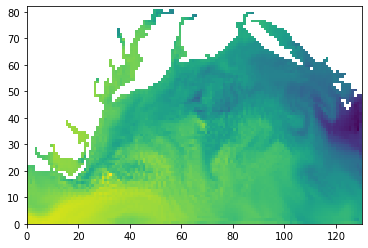

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy.ma as ma

T.data = ma.masked_invalid(T.data)

fig, ax = plt.subplots()

cs = ax.pcolormesh(T.data)

Iris knows about the metadata and can create fully annotated plots.

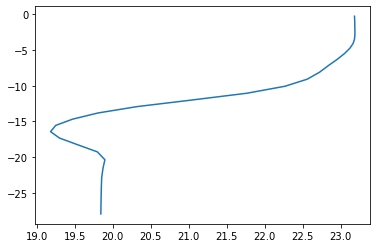

In [8]:
import iris.plot as qplt

qplt.plot(t_profile);

Be aware that too much automation may lead to some weird plots.

For example, the z-coord is in the x-direction and the automatic naming of the z to Sea surface height is above the reference ellipsoid in the second plot. Another example is the lack of proper coordinates in the first plot.

In these cases, manual plotting is more appropriate.

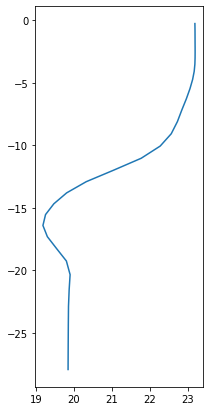

In [9]:
fig, ax = plt.subplots(figsize=(3, 7))

t = t_profile.data
z = t_profile.coord("sea_surface_height_above_reference_ellipsoid").points

ax.plot(t, z);

## UGRID-1.0 with pyugrid

The Unstructured Grids convention encompasses any type of grid topology,
and the details of the convention are documented in [https://ugrid-conventions.github.io/ugrid-conventions](http://bit.ly/2gvtmqQ).
Right now `pyugrid` supports only triangular topologies, more will be added in the near future.

In a nutshell the `pyugrid` parses and exposes the underlying grid topology in a python object.

In [10]:
import pyugrid

url = "http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc"
ugrid = pyugrid.UGrid.from_ncfile(url)

Sometimes the topology is incomplete but,
if the data is `UGRID` compliant,
`pyugrid` can derive the rest for you.

In [11]:
ugrid.build_edges()

The topology can be extracted from `ugrid` object and used for plotting.

In [12]:
lon = ugrid.nodes[:, 0]
lat = ugrid.nodes[:, 1]
triangles = ugrid.faces[:]

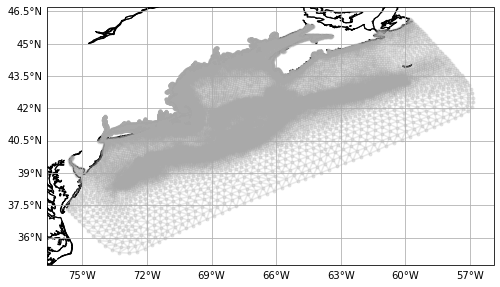

In [13]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=projection))
    ax.coastlines(resolution="50m")
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax


fig, ax = make_map()

kw = {"marker": ".", "linestyle": "-", "alpha": 0.25, "color": "darkgray"}
ax.triplot(lon, lat, triangles, **kw)
ax.coastlines();

There is some effort in the development community to integrate `pyugrid` into `iris` to augment the cube object to be both CF and UGRID aware.
It will add convenience plotting and slicing methods.

Check a longer `pyugrid` example [here](http://bit.ly/2gaZLCy).

## SGRID-0.3 with `pysgrid`

The Staggered Grid conventions help users to interpret grids from models like ROMS and DELFT,
where the variables are defined in different grids.
The specs are detailed in [https://sgrid.github.io/sgrid](https://sgrid.github.io/sgrid).

The `pysgrid` module is similar to `pyugrid`. The grid topology is parsed into a Python object with methods and attributes that translate the SGRID conventions.

In [14]:
import pysgrid

url = "http://geoport.whoi.edu/thredds/dodsC/coawst_4/use/fmrc/coawst_4_use_best.ncd"
sgrid = pysgrid.load_grid(url)

All the raw grid information is present, like edges, dimensions, padding, grid center, and slicing.

In [15]:
sgrid.edge1_coordinates, sgrid.edge1_dimensions, sgrid.edge1_padding

(('lon_u', 'lat_u'),
 'xi_u: xi_psi eta_u: eta_psi (padding: both)',
 [GridPadding(mesh_topology_var='grid', face_dim='eta_u', node_dim='eta_psi', padding='both')])

In [16]:
u_var = sgrid.u

u_var.center_axis, u_var.node_axis

(1, 0)

In [17]:
v_var = sgrid.v
v_var.center_axis, v_var.node_axis

(0, 1)

In [18]:
u_var.center_slicing, v_var.center_slicing

((slice(None, None, None),
  slice(None, None, None),
  slice(1, -1, None),
  slice(None, None, None)),
 (slice(None, None, None),
  slice(None, None, None),
  slice(None, None, None),
  slice(1, -1, None)))

The API is "raw" but comprehensive.
There is plenty of room to create convenience methods using the low level access provided by the library.

See below an example of the API and some simple convenience methods to `slice`, `pad`, `average`, and `rotate` the structure grid for plotting.

In [19]:
from netCDF4 import Dataset

# Compute the speed.
# **Rotate the grid.
# Average at the center.
from pysgrid.processing_2d import avg_to_cell_center, rotate_vectors, vector_sum

nc = Dataset(url)
u_velocity = nc.variables[u_var.variable]
v_velocity = nc.variables[v_var.variable]

v_idx = 0  # surface
time_idx = -1  # Last time step.

u = u_velocity[time_idx, v_idx, u_var.center_slicing[-2], u_var.center_slicing[-1]]
v = v_velocity[time_idx, v_idx, v_var.center_slicing[-2], v_var.center_slicing[-1]]


u = avg_to_cell_center(u, u_var.center_axis)
v = avg_to_cell_center(v, v_var.center_axis)


angles = nc.variables[sgrid.angle.variable][sgrid.angle.center_slicing]
u, v = rotate_vectors(u, v, angles)


speed = vector_sum(u, v)

\*\* CF convention does describe the angle variable for grids that needs rotation, but there is no action expected. For example, in the formula_terms, pysgrid must be improved to abstract that action when needed via a simpler method.

```xml
<entry id="angle_of_rotation_from_east_to_x">
    <canonical_units>degree</canonical_units>
    <grib></grib>
    <amip></amip>
    <description>The quantity with standard name angle_of_rotation_from_east_to_x is the angle, anticlockwise reckoned positive, between due East and (dr/di)jk, where r(i,j,k) is the vector 3D position of the point with coordinate indices (i,j,k).  It could be used for rotating vector fields between model space and latitude-longitude space.</description>
</entry>
```

In [20]:
lon_var_name, lat_var_name = sgrid.face_coordinates

sg_lon = getattr(sgrid, lon_var_name)
sg_lat = getattr(sgrid, lat_var_name)

lon = sgrid.center_lon[sg_lon.center_slicing]
lat = sgrid.center_lat[sg_lat.center_slicing]

Ideally all the steps above could be performed in the background, in a high level object method call, like the `iris` cube plotting methods.

Let's subset and center the velocity for better visualization (not a mandatory step but recommended).

In [21]:
def is_monotonically_increasing(arr, axis=0):
    return np.all(np.diff(arr, axis=axis) > 0)


def is_monotonically_decreasing(arr, axis=0):
    return np.all(np.diff(arr, axis=axis) < 0)


def is_monotonic(arr):
    return is_monotonically_increasing(arr) or is_monotonically_decreasing(arr)


def extent_bounds(arr, bound_position=0.5, axis=0):
    if not is_monotonic(arr):
        msg = "Array {!r} must be monotonic to guess bounds".format
        raise ValueError(msg(arr))

    x = arr.copy()
    x = np.c_[x[:, 0], (bound_position * (x[:, :-1] + x[:, 1:])), x[:, -1]]
    x = np.r_[
        x[0, :][None, ...],
        (bound_position * (x[:-1, :] + x[1:, :])),
        x[-1, :][None, ...],
    ]

    return x

In [22]:
import numpy as np

# For plotting reasons we will subsample every 10th point here
# 100 times less data!
sub = 10

lon = lon[::sub, ::sub]
lat = lat[::sub, ::sub]
u, v = u[::sub, ::sub], v[::sub, ::sub]
speed = speed[::sub, ::sub]

x = extent_bounds(lon)
y = extent_bounds(lat)

Now we can use quiver to plot the velocity components in a single grid. 

In [23]:
def make_map(projection=ccrs.PlateCarree(), figsize=(9, 9)):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

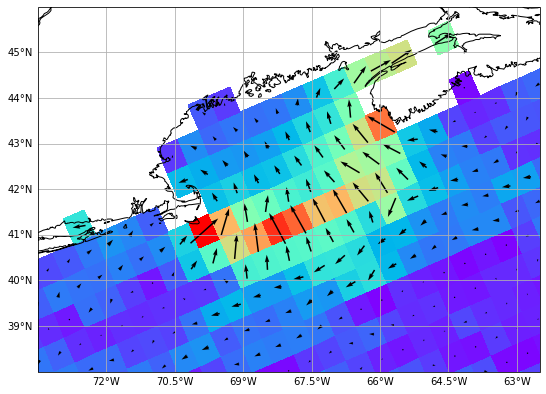

In [24]:
scale = 0.06

fig, ax = make_map()

kw = dict(scale=1.0 / scale, pivot="middle", width=0.003, color="black")
q = plt.quiver(lon, lat, u, v, zorder=2, **kw)

plt.pcolormesh(x, y, speed, zorder=1, cmap=plt.cm.rainbow)

c = ax.coastlines("10m")
ax.set_extent([-73.5, -62.5, 38, 46])

For more examples on `pysgrid` check this [post](http://bit.ly/2fKVk0x) out.